# Attempting to Beat a Zero-Shot Classifier with Classical NLP/ML Techniques

## Overview

This notebook investigates whether a traditional supervised NLP pipeline can outperform a strong **zero-shot baseline** on our real-world book-classification task.

The reference model is the widely used
**`facebook/bart-large-mnli`**, employed in a zero-shot setting to infer book genres from textual description (metadata) - in which it got a 77% accuracy.

Rather than relying on LLMs, we deliberately take steps back into the classical machine learning area to test a simpler hypothesis:

> With sufficient feature engineering and task-specific signal, classical models can compete - and sometimes outperform - zero-shot LLM classifiers - and potentially SOTA LLMs like GPT and DeepSeek.

In [1]:
# Basic Stack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline


In [3]:
import sys
import types

import requests
from tqdm import tqdm

tqdm.pandas()

In [4]:
books_cleaned_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/LLM/book_recommender/data/books_cleaned.csv"
books = pd.read_csv(books_cleaned_url)
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


## Loading Helper Functions from GitHub

To keep this notebook fully portable, helper functions are loaded directly from a raw GitHub file rather than from a local module.
This choice ensures that the notebook can be executed consistently across different environments:

* locally after cloning the repository,
* directly from GitHub,
* or inside runtimes such as Google Colab.

By fetching the utilities at runtime, we avoid fragile relative imports and eliminate problems about local folder structure.
The helper module is dynamically loaded into memory and registered in `sys.modules`, allowing its functions to be accessed exactly like a standard Python package.


In [ ]:
def import_from_url(url: str, module_name: str = "remote_module") -> types.ModuleType:
	"""
	Fetches a raw Python script from a URL and loads it as a module.

	Parameters
	----------
	url : str
		The raw URL of the Python file (e.g., from raw.githubusercontent.com).
	module_name : str
		The name to assign to the module in sys.modules.

	Returns
	-------
	types.ModuleType
		The loaded module object.
	"""
	# Fetch the raw code
	response = requests.get(url)
	response.raise_for_status()  # Ensure the request succeeded
	source_code = response.text

	# Create a new, empty module object
	module = types.ModuleType(module_name)

	# Populate the module by executing the source code in its namespace
	# This keeps functions/variables contained within 'module', not global
	exec(source_code, module.__dict__)

	#  Register it in sys.modules
	# This allows other imported modules to see it if necessary.
	sys.modules[module_name] = module

	return module

In [6]:
# GitHub URL
helper_utils_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/LLM/book_recommender/data/utils.py"

# Import it
utils = import_from_url(helper_utils_url, module_name="utils")

# It's now possible to access functions just like a normal package
# df_results = utils.evaluate_candidates_cls(candidates, X, y)
print(f"Module '{utils.__name__}' loaded successfully.")

Module 'utils' loaded successfully.


## Simplifying the Target Categories

The original dataset contains a rich and heterogeneous set of genre labels. While informative, this level of granularity is not statistically practical for supervised modelling with the available data.

To ensure reliable learning and stable evaluation, categories are collapsed into a binary distinction:

**Fiction** vs **Nonfiction**.

This simplification is intentional. The book descriptions themselves remain semantically rich and will later provide sufficient signal for recommendation and similarity tasks with the "Description" feature. However, for classification, the fiction/nonfiction boundary is an extremelly meaningful, well-defined axis that is both realistic and learnable.

In simpler terms:
> semantic richness is preserved in the dataset, while categorical noise is reduced in the labels.


In [ ]:
category_mapping = {
	"Fiction": "Fiction",
	"Juvenile Fiction": "Fiction",
	"Biography & Autobiography": "Nonfiction",
	"History": "Nonfiction",
	"Literary Criticism": "Nonfiction",
	"Philosophy": "Nonfiction",
	"Religion": "Nonfiction",
	"Comics & Graphic Novels": "Fiction",
	"Drama": "Fiction",
	"Juvenile Nonfiction": "Nonfiction",
	"Science": "Nonfiction",
	"Poetry": "Fiction",
}

books["simple_categories"] = books["categories"].map(category_mapping)

In [ ]:
# Extracting rows that already have labels for training/testing
labelled = books[books["simple_categories"].notna()].copy()
# Extracting rows that need labels
unlabelled = books[books["simple_categories"].isna()].copy()

# Using description for the primary semantic signal
X_labelled = labelled["description"]
y_labelled = labelled["simple_categories"]

X_train, X_test, y_train, y_test = train_test_split(
	X_labelled, y_labelled, test_size=0.2, random_state=42, stratify=y_labelled
)

### Baseline Candidates

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline(
	steps=[
		("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=20000)),
		("clf", LogisticRegression(C=10, max_iter=1000, random_state=42)),
	]
)

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred_logreg))

              precision    recall  f1-score   support

     Fiction       0.89      0.97      0.93       551
  Nonfiction       0.90      0.67      0.77       198

    accuracy                           0.89       749
   macro avg       0.90      0.82      0.85       749
weighted avg       0.90      0.89      0.89       749



Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters Found: {'clf__C': 1, 'clf__class_weight': None, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 88.91%
              precision    recall  f1-score   support

     Fiction       0.90      0.97      0.94       551
  Nonfiction       0.90      0.71      0.80       198

    accuracy                           0.90       749
   macro avg       0.90      0.84      0.87       749
weighted avg       0.90      0.90      0.90       749



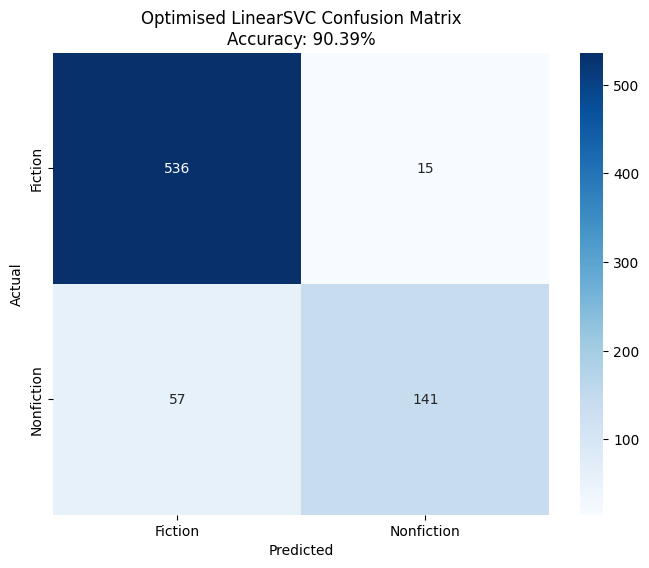

In [ ]:
from sklearn.svm import LinearSVC

books_grid = books.dropna(subset=["simple_categories"]).copy()
X = books_grid["description"]
y = books_grid["simple_categories"]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.20, random_state=42, stratify=y
)

# The Pipeline
# We wrap the Vectorizer and the Model into a single object.
# This prevents data leakage during Cross-Validation.
pipe_grid = Pipeline([
	("tfidf", TfidfVectorizer(stop_words="english")),
	("clf", LinearSVC(random_state=42, dual="auto")),
])

# The Hyperparameter Grid
# We are going to test multiple combinations to find the "Perfect" model.
param_grid = {
	# Vectorizer tuning:
	# Does the model need bigrams (1,2) or just unigrams (1,1)?
	"tfidf__ngram_range": [(1, 1), (1, 2)],
	# Vocabulary size: Is more data better, or does it introduce noise?
	"tfidf__max_features": [5000, 10000, 20000],
	# Model tuning:
	# Small C = soft margin (smoother boundary).
	"clf__C": [0.1, 1, 10, 100],
	# 'balanced' forces the model to pay more attention to the minority class.
	"clf__class_weight": [None, "balanced"],
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(pipe_grid, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2%}")

# Final Evaluation on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Fiction", "Nonfiction"])
# Calculate accuracy for the plot title
acc = best_model.score(X_test, y_test)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
	cm,
	annot=True,
	fmt="d",
	cmap="Blues",
	xticklabels=["Fiction", "Nonfiction"],
	yticklabels=["Fiction", "Nonfiction"],
	ax=ax,
)
ax.set_title(f"Optimised LinearSVC Confusion Matrix\nAccuracy: {acc:.2%}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

              precision    recall  f1-score   support

     Fiction       0.93      0.94      0.94       551
  Nonfiction       0.82      0.82      0.82       198

    accuracy                           0.91       749
   macro avg       0.88      0.88      0.88       749
weighted avg       0.91      0.91      0.91       749



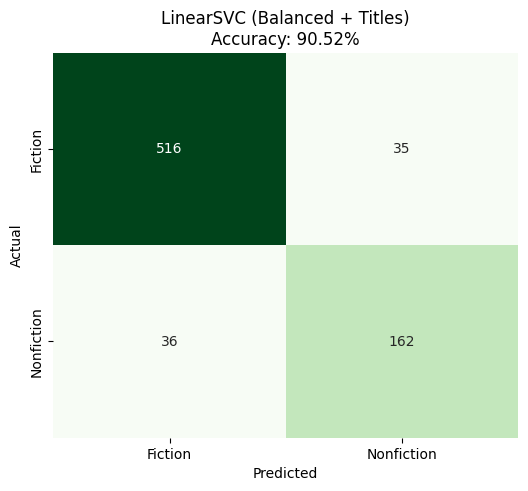


Top 10 Words driving 'Fiction' prediction (Negative Coefs):
novel: -2.984
stories: -1.387
finds: -1.266
reprint: -1.119
play: -1.043
young: -0.933
dreams: -0.869
reissue: -0.838
daughter: -0.796
characters: -0.789

Top 10 Words driving 'Nonfiction' prediction (Positive Coefs):
history: 1.926
life: 1.868
describes: 1.814
memoir: 1.728
biography: 1.662
account: 1.546
autobiography: 1.260
theory: 1.216
recounts: 1.207
guide: 1.182


In [ ]:
# Feature Engineering (The Signal Booster)
books_eda = books.dropna(subset=["simple_categories"]).copy()

# Concatenating Title + Description
# Titles often contain "History", "Guide", "Life of".
books_eda["text_feature"] = (
	books_eda["title_and_subtitle"].fillna("") + " " + books_eda["description"].fillna("")
)

X = books_eda["text_feature"]
y = books_eda["simple_categories"]

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.20, random_state=42, stratify=y
)

# The "Dictator" Pipeline
pipe_dictator = Pipeline(
	steps=[
		("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=20000)),
		("clf", LinearSVC(random_state=42, class_weight="balanced", C=0.5)),
	]
)
# raining
pipe_dictator.fit(X_train, y_train)

# Evaluation
y_pred = pipe_dictator.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Visualisation
cm = confusion_matrix(y_test, y_pred, labels=["Fiction", "Nonfiction"])
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
	cm,
	annot=True,
	fmt="d",
	cmap="Greens",
	cbar=False,
	xticklabels=["Fiction", "Nonfiction"],
	yticklabels=["Fiction", "Nonfiction"],
)
ax.set_title(f"LinearSVC (Balanced + Titles)\nAccuracy: {acc:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

# Let's see exactly what the model considers "Fiction" vs "Nonfiction"
feature_names = pipe_dictator.named_steps["tfidf"].get_feature_names_out()
coefs = pipe_dictator.named_steps["clf"].coef_.flatten()

# Zip coefficients with words
top_features = sorted(zip(coefs, feature_names), key=lambda x: x[0])

print("\nTop 10 Words driving 'Fiction' prediction (Negative Coefs):")
for coef, feat in top_features[:10]:
	print(f"{feat}: {coef:.3f}")

print("\nTop 10 Words driving 'Nonfiction' prediction (Positive Coefs):")
for coef, feat in top_features[-10:][::-1]:
	print(f"{feat}: {coef:.3f}")

In [ ]:
# Get the indices of the test set
test_indices = X_test.index

# Create a DataFrame of the errors
errors_df = books.loc[test_indices].copy()
errors_df["True Label"] = y_test
errors_df["Predicted Label"] = y_pred

# Filter for mistakes only
mistakes = errors_df[errors_df["True Label"] != errors_df["Predicted Label"]].copy()

# Check the "False Nonfiction"
print("\nFiction books mistook for Nonfiction: \n")
for (
	i,
	row,
) in mistakes[mistakes["True Label"] == "Fiction"].head(3).iterrows():
	print(f"Title: {row['title_and_subtitle']}")
	print(f"Desc snippet: {row['description']}")

# Check the "False Fiction"
print("\nNonfiction books mistook for Fiction: \n")
for i, row in mistakes[mistakes["True Label"] == "Nonfiction"].head(3).iterrows():
	print(f"Title: {row['title_and_subtitle']}")
	print(f"Desc snippet: {row['description']}")


Fiction books mistook for Nonfiction: 

Title: Until I Find You
Desc snippet: Chronicles the life and times of actor Jack Burns, whose unique bond with his mother, Alice, a Toronto tattoo artist, and their search for his missing father, William, shapes his relationships with women and his Hollywood career.
Title: Faust
Desc snippet: Loosely connected with Part One and the German legend of Faust, Part Two is a dramatic epic rather than a strictly constructed drama. It is conceived as an act of homage to classical Greek culture and inspired above all by the world of story-telling and myth at the heart of the Greektradition, as well as owing some of its material to the Arabian Nights tales.The restless and ruthless hero, advised by his cynical demon-companion Mephistopheles, visits classical Greece i search of the beautiful Helen of Troy. Returning to modern times, he seeks to crown his career by gaining control of the elements, and at his death is carried up into the unkown regions,stil

In [ ]:
# !pip -q install spacy
# !python -m spacy download en_core_web_trf

In [ ]:
import spacy

# Load Spacy Model (Disable NER/Parser for speed, we only need Tagger/Lemmatizer)
nlp = spacy.load("en_core_web_trf", disable=["parser", "ner"])


def spacy_preprocessor(text):
	if not isinstance(text, str):
		return ""

	doc = nlp(text.lower())

	# We keep Nouns (topics), Verbs (actions), Adjectives (descriptors)
	# We explicitly KEEP Proper Nouns (PROPN) because names are often strong signals
	# (e.g., 'Hitler' implies History, 'Gandalf' implies Fiction)
	allowed_pos = {"NOUN", "VERB", "ADJ", "PROPN"}

	# The lemma_ attribute gives us the root form (finds -> find)
	tokens = [token.lemma_ for token in doc if token.pos_ in allowed_pos and not token.is_stop]

	return " ".join(tokens)

100%|██████████| 3743/3743 [09:58<00:00,  6.25it/s]



Spacy + Author + LinearSVC Report

              precision    recall  f1-score   support

     Fiction       0.93      0.95      0.94       551
  Nonfiction       0.86      0.80      0.83       198

    accuracy                           0.91       749
   macro avg       0.89      0.88      0.88       749
weighted avg       0.91      0.91      0.91       749



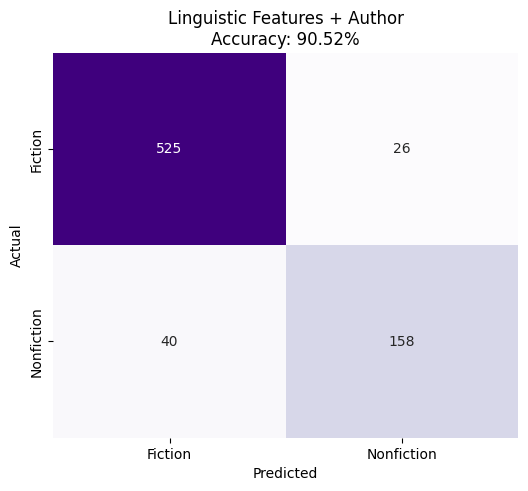


Top Lemmatised Signals for NONFICTION:
describe: 1.996
history: 1.877
memoir: 1.727
biography: 1.716
account: 1.656
life: 1.602
discuss: 1.426
autobiography: 1.401
guide: 1.342
book: 1.244

Top Lemmatised Signals for FICTION:
novel: -3.033
find: -1.257
reprint: -1.213
story: -1.170
play: -0.996
young: -0.966
murder: -0.900
year old: -0.848
daughter: -0.843
friend: -0.811


In [ ]:
from sklearn.svm import LinearSVC

books_eda = books.dropna(subset=["simple_categories"]).copy()

# Feature Engineering: Author + Title + Description
# We add the author explicitly.
raw_text = (
	books_eda["authors"].fillna("")
	+ " "
	+ books_eda["title_and_subtitle"].fillna("")
	+ " "
	+ books_eda["description"].fillna("")
)

books_eda["linguistic_feature"] = raw_text.progress_apply(spacy_preprocessor)

X = books_eda["linguistic_feature"]
y = books_eda["simple_categories"]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.20, random_state=42, stratify=y
)

# The Pipeline (Simpler now, because the heavy lifting was done in preprocessing)
pipe_with_spacy = Pipeline([
	("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
	("clf", LinearSVC(random_state=42, class_weight="balanced", C=0.5)),
])
pipe_with_spacy.fit(X_train, y_train)
y_pred = pipe_with_spacy.predict(X_test)

print("\nSpacy + Author + LinearSVC Report\n")
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Fiction", "Nonfiction"])
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
	cm,
	annot=True,
	fmt="d",
	cmap="Purples",
	cbar=False,
	xticklabels=["Fiction", "Nonfiction"],
	yticklabels=["Fiction", "Nonfiction"],
)
ax.set_title(f"Linguistic Features + Author\nAccuracy: {acc:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

# Inspecting the new Features
feature_names = pipe_with_spacy.named_steps["tfidf"].get_feature_names_out()
coefs = pipe_with_spacy.named_steps["clf"].coef_.flatten()
top_features = sorted(zip(coefs, feature_names), key=lambda x: x[0])

print("\nTop Lemmatised Signals for NONFICTION:")
for coef, feat in top_features[-10:][::-1]:
	print(f"{feat}: {coef:.3f}")

print("\nTop Lemmatised Signals for FICTION:")
for coef, feat in top_features[:10]:
	print(f"{feat}: {coef:.3f}")

In [ ]:
X = books_eda["linguistic_feature"]
y = books_eda["simple_categories"]

pipe_grid_spacy = Pipeline(
	steps=[
		("tfidf", TfidfVectorizer(stop_words="english")),
		("clf", LinearSVC()),  # Placeholder
	]
)

param_grid = {
	"clf": [LinearSVC(random_state=42)],
	"clf__C": [0.1, 0.5, 1.0, 1.5],
	"clf__class_weight": ["balanced", None],
	"tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
	"tfidf__min_df": [1, 5, 10],
	"tfidf__max_df": [0.5, 0.75, 1.0],
	"tfidf__max_features": [10000, 20000],
	"tfidf__use_idf": [True, False],
}


cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_spacy = GridSearchCV(
	estimator=pipe_grid_spacy,
	param_grid=param_grid,
	cv=cv_strategy,
	scoring="balanced_accuracy",
	n_jobs=-1,
	verbose=1,
)

grid_spacy.fit(X=X_train, y=y_train)
y_pred = grid_spacy.predict(X_test)

print(f"Best Params: {grid_spacy.best_params_}")
print(f"Best Accuracy: {grid_spacy.best_score_:.2%}")
print(classification_report(y_true=y_test, y_pred=y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Params: {'clf': LinearSVC(random_state=42), 'clf__C': 0.5, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.5, 'tfidf__max_features': 20000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False}
Best Accuracy: 85.98%
              precision    recall  f1-score   support

     Fiction       0.93      0.93      0.93       551
  Nonfiction       0.80      0.81      0.81       198

    accuracy                           0.90       749
   macro avg       0.87      0.87      0.87       749
weighted avg       0.90      0.90      0.90       749



### Out-of-Fold (OOF) Predictions

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict

df_audit = books_eda.dropna(subset=["simple_categories"]).copy()

X = df_audit["linguistic_feature"]
y = df_audit["simple_categories"]

# The Calibrated Champion
# We wrap LinearSVC to get .predict_proba() support
svm_model = LinearSVC(C=0.5, class_weight="balanced", random_state=42)
calibrated_svc = CalibratedClassifierCV(svm_model, cv=5, method="sigmoid")

pipe_oof = Pipeline([
	("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
	("clf", calibrated_svc),
])

# Generating Out-of-Fold Probabilities
y_probas = cross_val_predict(pipe_oof, X, y, cv=5, method="predict_proba", n_jobs=-1)

# Building the Audit Report
# We capture the probability of the PREDICTED class
y_pred_indices = np.argmax(y_probas, axis=1)
classes = np.unique(y)
y_pred_labels = classes[y_pred_indices]
y_confidences = np.max(y_probas, axis=1)

df_audit["model_prediction"] = y_pred_labels
df_audit["model_confidence"] = y_confidences

# Identifying the "Lying" Labels
# We look for:
# A) Disagreement (Model says X, Label says Y)
# B) High Confidence (Model is >95% sure)
threshold = 0.95
df_audit["is_suspect"] = (df_audit["simple_categories"] != df_audit["model_prediction"]) & (
	df_audit["model_confidence"] > threshold
)

suspects = df_audit[df_audit["is_suspect"]].sort_values("model_confidence", ascending=False)
print(f"Audit Complete. Found {len(suspects)} high-confidence label errors.\n")

Audit Complete. Found 41 high-confidence label errors.



In [ ]:
print("Top 5 most suspicious rows")
for i, row in suspects.head(5).iterrows():
	print(f"Book: {row['title_and_subtitle']}")
	print(
		f"Label: {row['simple_categories']} | Model: {row['model_prediction']} ({row['model_confidence']:.2%})"
	)
	print(f"Snippet: {str(row['description'])[:350]}...")
	print("-" * 50)

Top 5 most suspicious rows
Book: Writings, 1878-1899
Label: Fiction | Model: Nonfiction (99.79%)
Snippet: William James, a member of America's most illustrious intellectual family, is widely acclaimed as the country's foremost philosopher, the first of its psychologists, and a champion of religious pluralism. As the apostle of pragmatism, his influence on American thought is as strong now as it has ever been. James's emphasis on the creative power of f...
--------------------------------------------------
Book: Oliver Twist
Label: Nonfiction | Model: Fiction (99.77%)
Snippet: This wonderful series is a quick way into a range of exciting stories, from the chilling tale of Frankenstein, to the gripping adventure of Treasure Island and the powerful animal story of Call of the Wild. Fast-moving and accessible, each story is a shortened, dramatically illustrated version of the classic novel, which loses none of the strength ...
--------------------------------------------------
Book: When I

In [ ]:
def oof_audit(row):
	"""
	Decides whether to trust the Model or the Label based on keywords.
	"""
	prediction = row["model_prediction"]
	current_label = row["simple_categories"]

	# We check BOTH the linguistic feature (lemmatized) and the raw title (for proper nouns)
	lemma_text = str(row["linguistic_feature"]).lower()
	raw_title = str(row["title_and_subtitle"]).lower()

	# Model says FICTION, Label says NONFICTION
	# (The Oliver Twist / Memoir Scenario)
	if prediction == "Fiction" and current_label == "Nonfiction":
		# The Memoir/Bio Guard (Updated to SINGULAR lemmas)
		# "letter" not "letters", "story" not "stories"
		bio_keywords = [
			"memoir",
			"autobiography",
			"letter",
			"biography",
			"life",
			"journal",
			"diary",
		]

		# The Journalism/History Guard (Protects 'Hiroshima' and 'Mob Life')
		nonfic_keywords = ["history", "report", "account", "true", "war", "investigation"]

		# The Study Guide Guard (Protects 'CliffsNotes', 'Companion')
		guide_keywords = ["guide", "note", "companion", "summary", "analysis"]

		# If ANY non-fiction signal is present, TRUST THE LABEL (Don't flip)
		all_guards = bio_keywords + nonfic_keywords + guide_keywords

		if any(k in lemma_text for k in all_guards) or any(k in raw_title for k in all_guards):
			return current_label  # Keep Nonfiction
		else:
			return prediction  # Flip to Fiction (It's Oliver Twist)

	# Model says NONFICTION, Label says FICTION
	# (The William James / Julian Barnes Scenario)
	elif prediction == "Nonfiction" and current_label == "Fiction":
		# The "Julian Barnes" Exception
		# If the Model thinks it's Nonfiction, we usually trust it, UNLESS the title explicitly says "Novel"
		if "novel" in raw_title or "story" in raw_title:
			return current_label  # Keep Fiction (It's a trap!)

		# Look for strong Academic signals
		academic_keywords = [
			"philosophy",
			"psychology",
			"essay",
			"criticism",
			"series",
			"edition",
			"work",
		]

		if any(k in lemma_text for k in academic_keywords):
			return prediction
		else:
			return current_label

	return current_label

In [35]:
# Assume 'suspects' is the dataframe you generated in the previous step
# We work on a copy to be safe
cleaner_df = suspects.copy()

# Apply the logic
cleaner_df["final_category"] = cleaner_df.apply(oof_audit, axis=1)

# Let's see the results of our surgery
changes = cleaner_df[cleaner_df["simple_categories"] != cleaner_df["final_category"]]

print(f"OOF audit proposed {len(changes)} specific fixes.")
print("\nExamples of Auto-Fixes: ")
for i, row in changes.head(24).iterrows():
	print(f"Book: {row['title_and_subtitle']}")
	print(f"Was: {row['simple_categories']} -> Now: {row['final_category']}")
	print("-" * 30)

OOF audit proposed 24 specific fixes.

Examples of Auto-Fixes: 
Book: Writings, 1878-1899
Was: Fiction -> Now: Nonfiction
------------------------------
Book: Oliver Twist
Was: Nonfiction -> Now: Fiction
------------------------------
Book: The Last Days of Socrates
Was: Fiction -> Now: Nonfiction
------------------------------
Book: The Tale of The Flopsy Bunnies
Was: Nonfiction -> Now: Fiction
------------------------------
Book: Beatrice's Goat
Was: Nonfiction -> Now: Fiction
------------------------------
Book: Mansfield Park
Was: Nonfiction -> Now: Fiction
------------------------------
Book: King Henry IV Part 2: Second Series
Was: Fiction -> Now: Nonfiction
------------------------------
Book: Ten Great Works of Philosophy
Was: Fiction -> Now: Nonfiction
------------------------------
Book: The Scarlet Letter
Was: Fiction -> Now: Nonfiction
------------------------------
Book: Hunger
Was: Nonfiction -> Now: Fiction
------------------------------
Book: Ego & Hubris: The Michael M

In [37]:
# Apply the Fixes permanently
books_cleaned = books.copy()

# We map the fixes from our 'cleaner_df' back to the main dataframe
fix_map = cleaner_df["final_category"].to_dict()
updates = pd.Series(fix_map)

# Only update the rows that exist in our 'suspects' list
books_cleaned.loc[updates.index, "simple_categories"] = updates

# Final Sanity Check
print("Final Distribution")
print(books_cleaned["simple_categories"].value_counts())

Final Distribution
simple_categories
Fiction       2760
Nonfiction     983
Name: count, dtype: int64


In [ ]:
books_df = books_cleaned.copy()
books_df = books_df.dropna(subset=["simple_categories"]).copy()


books_df["text"] = (
	books_df["title_and_subtitle"].fillna("") + " " + books_df["description"].fillna("")
)

X = books_df["text"]
y = books_df["simple_categories"]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.20, random_state=42, stratify=y
)

base_svc = LinearSVC(C=0.1, class_weight="balanced", random_state=42)
calibrated_svc = CalibratedClassifierCV(base_svc, cv=5)

final_pipe = Pipeline([
	("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=20000)),
	("clf", calibrated_svc),
])

final_pipe.fit(X_train, y_train)

# Get Probabilities on Test Set
probs = final_pipe.predict_proba(X_test)
max_prob = np.max(probs, axis=1)
preds = final_pipe.predict(X_test)

results = pd.DataFrame(
	data={
		"True_Label": y_test,
		"Pred_Label": preds,
		"Confidence": max_prob,
		"Is_Error": y_test != preds,
	}
)

threshold = 0.80  # Let's say we send anything below 80% confidence to DeepSeek
to_llm = results[results["Confidence"] < threshold]
accuracy_above_threshold = results[results["Confidence"] >= threshold]["Is_Error"].mean()

print(f"Total Test Samples: {len(results)}")
print(f"Sent to LLM: {len(to_llm)} ({len(to_llm) / len(results):.1%})")
print(f"Cost Savings: {1 - len(to_llm) / len(results):.1%}")
print(f"Error Rate of the 'SVM-Only' portion (High Confidence): {accuracy_above_threshold:.2%}")

Total Test Samples: 749
Sent to LLM: 124 (16.6%)
Cost Savings: 83.4%
Error Rate of the 'SVM-Only' portion (High Confidence): 3.52%


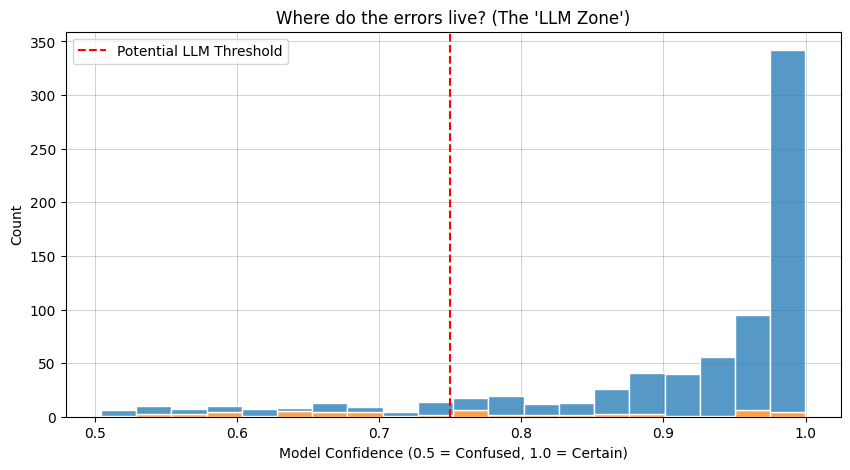

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
	data=results, x="Confidence", hue="Is_Error", multiple="stack", bins=20, edgecolor="white"
)

ax.set(
	title="Where do the errors live? (The 'LLM Zone')",
	xlabel="Model Confidence (0.5 = Confused, 1.0 = Certain)",
)
ax.axvline(0.75, color="r", linestyle="--", label="Potential LLM Threshold")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)

plt.legend()
plt.show()